In [1]:
import os
import cv2
import json
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime as dt

In [2]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import mobilenet_v3
from tensorflow.keras.layers import Dense,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.python.client import device_lib
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(device_lib.list_local_devices()))

Num GPUs Available:  1


In [4]:
IMG_SIZE = 224
batch_size=100

In [5]:
%%time
ds_train=tf.keras.preprocessing.image_dataset_from_directory("D:\\ECG DB\\FourClasseswith15percent",
                                                             labels='inferred',label_mode="int",
                                                             class_names=['AF','NSR','PAC','PVC'],color_mode='rgb',
                                                             batch_size=batch_size,image_size=(IMG_SIZE,IMG_SIZE), #reshapeauto
                                                             shuffle=True,seed=123,validation_split=0.4,subset="training")

Found 2417 files belonging to 4 classes.
Using 1451 files for training.
CPU times: total: 125 ms
Wall time: 115 ms


In [6]:
%%time
ds_validate=tf.keras.preprocessing.image_dataset_from_directory("D:\\ECG DB\\FourClasseswith15percent",
                                                                labels='inferred',label_mode="int",
                                                                class_names=['AF','NSR','PAC','PVC'],color_mode='rgb',
                                                                batch_size=batch_size,image_size=(IMG_SIZE,IMG_SIZE), #reshapeauto
                                                                shuffle=True,seed=123,validation_split=0.4,subset="validation")

Found 2417 files belonging to 4 classes.
Using 966 files for validation.
CPU times: total: 109 ms
Wall time: 92.3 ms


In [7]:
class_names = ds_train.class_names
print(class_names)

['AF', 'NSR', 'PAC', 'PVC']


(100, 224, 224, 3)
(100,)


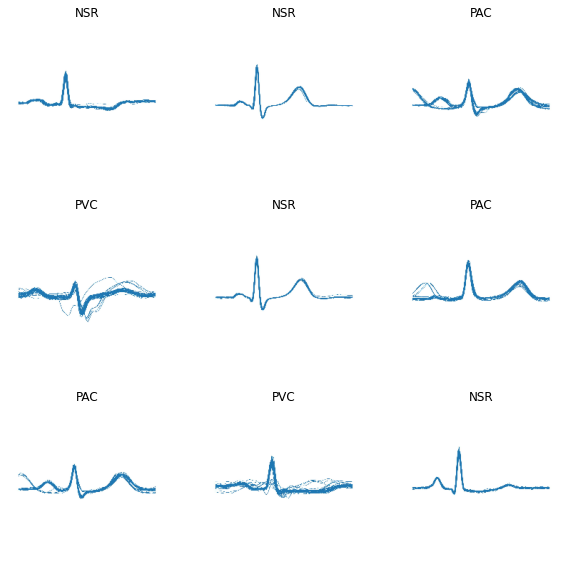

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [9]:
%%time
val_batches = tf.data.experimental.cardinality(ds_validate)
validation_dataset = ds_validate.skip(val_batches //3)
test_dataset = ds_validate.take(val_batches //3)

CPU times: total: 0 ns
Wall time: 1.03 ms


In [10]:
%%time
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 3
CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = ds_train.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

CPU times: total: 0 ns
Wall time: 2.08 ms


In [12]:
#data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomZoom(.5,.5),])

In [13]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
rescale = tf.keras.layers.Rescaling(1./223.5, offset=-1)

In [15]:
# Create the base model from the pre-trained model MV3
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),
                                                  include_top=False,
                                                  weights='imagenet',
                                                  classifier_activation='softmax')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(100, 7, 7, 1280)


In [17]:
base_model.trainable = False #Freeze the convolutional base

In [18]:
# Let's take a look at the base model architecture
base_model.summary()
len(base_model.layers)

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

237

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(100, 1280)


prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [20]:
number_of_classes = 4
inputs = tf.keras.Input(shape=(224,224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
      # call it on the given tensor
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation = None  #tf.keras.activations.softmax
outputs =outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation,name="predictions")(x) 
efficientNet = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.01
efficientNet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [22]:
%%time
first_hist=efficientNet.fit(train_dataset, validation_data=val_dataset, batch_size=100, epochs=100)


Epoch 1/100
15/15 [==============================] - 61s 4s/step - loss: 0.8382 - sparse_categorical_accuracy: 0.6733 - val_loss: 0.8784 - val_sparse_categorical_accuracy: 0.7207
Epoch 2/100
15/15 [==============================] - 56s 4s/step - loss: 0.2897 - sparse_categorical_accuracy: 0.8932 - val_loss: 0.7250 - val_sparse_categorical_accuracy: 0.8468
Epoch 3/100
15/15 [==============================] - 54s 4s/step - loss: 0.1901 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.8529
Epoch 4/100
15/15 [==============================] - 54s 4s/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.5856 - val_sparse_categorical_accuracy: 0.8859
Epoch 5/100
15/15 [==============================] - 54s 4s/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.5221 - val_sparse_categorical_accuracy: 0.9099
Epoch 6/100
15/15 [==============================] - 55s 4s/step - loss: 0.0960 - sparse_categorical_accu

15/15 [==============================] - 57s 4s/step - loss: 0.0076 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0574 - val_sparse_categorical_accuracy: 0.9835
Epoch 47/100
15/15 [==============================] - 57s 4s/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.0563 - val_sparse_categorical_accuracy: 0.9835
Epoch 48/100
15/15 [==============================] - 57s 4s/step - loss: 0.0075 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0563 - val_sparse_categorical_accuracy: 0.9835
Epoch 49/100
15/15 [==============================] - 57s 4s/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0570 - val_sparse_categorical_accuracy: 0.9835
Epoch 50/100
15/15 [==============================] - 57s 4s/step - loss: 0.0066 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0581 - val_sparse_categorical_accuracy: 0.9835
Epoch 51/100
15/15 [==============================] - 57s 4s/step - loss: 0.0069 - sparse_categorical_accuracy: 0

15/15 [==============================] - 57s 4s/step - loss: 0.0026 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0609 - val_sparse_categorical_accuracy: 0.9820
Epoch 92/100
15/15 [==============================] - 57s 4s/step - loss: 0.0032 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0615 - val_sparse_categorical_accuracy: 0.9820
Epoch 93/100
15/15 [==============================] - 57s 4s/step - loss: 0.0025 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0617 - val_sparse_categorical_accuracy: 0.9820
Epoch 94/100
15/15 [==============================] - 58s 4s/step - loss: 0.0023 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0611 - val_sparse_categorical_accuracy: 0.9820
Epoch 95/100
15/15 [==============================] - 55s 4s/step - loss: 0.0022 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0614 - val_sparse_categorical_accuracy: 0.9820
Epoch 96/100
15/15 [==============================] - 53s 4s/step - loss: 0.0021 - sparse_categorical_accuracy: 1

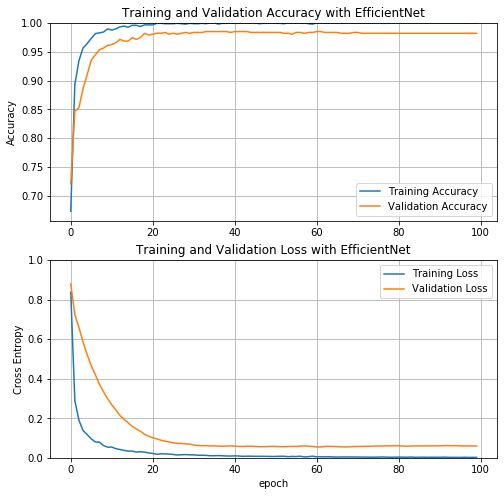

In [23]:
acc = first_hist.history['sparse_categorical_accuracy']
val_acc = first_hist.history['val_sparse_categorical_accuracy']

loss = first_hist.history['loss']
val_loss = first_hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.style.use('_classic_test_patch')
plt.grid(True)

plt.subplot(2, 1, 1)
plt.style.use('_classic_test_patch')
plt.grid(True)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy with EfficientNet')

plt.subplot(2, 1, 2)
plt.style.use('_classic_test_patch')
plt.grid(True)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss with EfficientNet')
plt.xlabel('epoch')
plt.show()

In [24]:
%%time
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy=efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy=efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy=efficientNet.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 11s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [==============================] - 8s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [==============================] - 8s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [==============================] - 8s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [==============================] - 8s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [==============================] - 8s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [==============================] - 8s 3s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9833
Test accuracy : 0.9833333492279053
3/3 [============================

In [25]:
print(test_dataset.as_numpy_iterator().next()[1])

[3 1 0 3 3 0 1 3 0 3 3 1 3 2 1 2 2 3 1 2 3 1 2 3 2 2 3 1 3 1 0 0 0 0 1 3 3
 3 2 0 0 3 2 0 2 0 0 1 1 3 0 1 2 0 3 1 1 1 3 2 0 1 3 0 3 1 1 1 3 2 2 3 2 0
 0 2 1 3 2 2 0 2 3 0 3 3 3 2 3 3 2 3 2 3 2 1 1 1 3 1]


In [26]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = efficientNet.predict(image_batch)
predictions.shape

(100, 4)

In [27]:
predictions

array([[  0.2855214 ,  -6.084456  ,   5.535301  ,   3.3645654 ],
       [  1.8515843 ,  -2.1126432 ,  -6.645844  ,   9.683874  ],
       [ 12.070213  ,  -2.3553948 ,  -4.886559  ,  -7.2330317 ],
       [ -5.0314035 ,   0.8712164 ,  11.106563  ,  -3.9367995 ],
       [  8.254971  ,   3.8042102 ,  -4.1498003 ,  -8.218339  ],
       [ -3.1749694 ,  -3.6476626 ,   8.991562  ,  -2.2084222 ],
       [ -4.369063  ,  -8.472587  ,  -4.921823  ,   9.940246  ],
       [ -5.6664214 ,  -4.515662  ,  -8.555852  ,  14.336076  ],
       [  0.39220345,  -7.743562  ,  -0.9209943 ,  12.400071  ],
       [ 10.550736  ,   0.44424182,  -7.4403987 ,  -6.813724  ],
       [  2.2915356 ,  -5.997229  ,   7.515517  ,  -3.2359946 ],
       [ -8.145249  ,  -1.6969007 ,   4.926398  ,   8.344852  ],
       [ -3.0271451 ,   7.78428   ,   0.38211066,  -5.5756426 ],
       [  3.7356167 ,   8.775444  ,  -6.591216  ,  -4.8932686 ],
       [  4.543307  ,  -3.2017057 ,   1.77092   ,  -3.1895642 ],
       [ -2.0397499 ,  -7

In [28]:
np.argmax(predictions[1],axis=0)

3

In [29]:
predicted_classes=[]
for i in range(100):
    predicted_class=np.argmax(predictions[i])
    predicted_classes.append(predicted_class)

In [30]:
np.array(predicted_classes)

array([2, 3, 0, 2, 0, 2, 3, 3, 3, 0, 2, 3, 1, 1, 0, 2, 3, 0, 1, 3, 3, 1,
       2, 1, 3, 0, 1, 1, 3, 1, 3, 1, 0, 2, 3, 1, 2, 2, 0, 0, 1, 0, 0, 2,
       2, 3, 0, 3, 0, 3, 3, 3, 2, 0, 3, 1, 2, 0, 3, 1, 0, 2, 2, 3, 1, 2,
       1, 1, 3, 2, 0, 2, 3, 2, 1, 0, 1, 0, 0, 3, 1, 0, 3, 2, 1, 1, 0, 1,
       3, 0, 2, 1, 2, 3, 0, 3, 1, 2, 3, 2], dtype=int64)

In [31]:
label_batch

array([2, 3, 0, 2, 0, 2, 3, 3, 3, 0, 2, 3, 1, 1, 0, 2, 3, 0, 1, 3, 3, 1,
       2, 1, 3, 0, 1, 1, 3, 1, 3, 1, 0, 2, 3, 1, 2, 2, 0, 0, 1, 0, 0, 2,
       2, 3, 0, 3, 0, 3, 3, 3, 2, 0, 3, 1, 2, 0, 0, 1, 0, 2, 2, 3, 1, 2,
       1, 1, 3, 2, 0, 2, 3, 2, 1, 0, 1, 0, 0, 3, 1, 0, 3, 2, 1, 1, 0, 1,
       3, 0, 2, 1, 2, 3, 0, 3, 1, 2, 3, 2])

    y_Actual  y_Predicted
0          2            2
1          3            3
2          0            0
3          2            2
4          0            0
..       ...          ...
95         3            3
96         1            1
97         2            2
98         3            3
99         2            2

[100 rows x 2 columns]


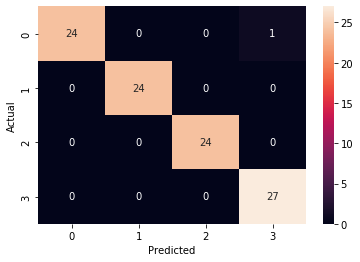

In [32]:
# Confusion Matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true=label_batch
y_pred=np.array(predicted_classes)
confusion_matrix(y_true, y_pred)

data = {'y_Actual': y_true,
        'y_Predicted': y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [33]:
confusion_matrix


Predicted,0,1,2,3
Actual,,,,
0,24,0,0,1
1,0,24,0,0
2,0,0,24,0
3,0,0,0,27


In [34]:
def AF_SandS (conf_matrix):
    TP= conf_matrix[0][0]
    TN= (conf_matrix[1][1]+conf_matrix[2][2]+conf_matrix[3][3]+
               conf_matrix[1][2]+conf_matrix[1][3]+conf_matrix[2][1]+conf_matrix[2][3]+conf_matrix[3][1]+conf_matrix[3][2])
    FP= conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[0][3]
    FN= conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('AF')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 

    
def NSR_SandS (conf_matrix):
    TP= conf_matrix[1][1]
    TN= (conf_matrix[0][0]+conf_matrix[2][2]+conf_matrix[3][3]+
               conf_matrix[0][2]+conf_matrix[0][3]+conf_matrix[2][0]+conf_matrix[2][3]+conf_matrix[3][0]+conf_matrix[3][2])
    FP= conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[1][3]
    FN= conf_matrix[0][1]+conf_matrix[2][1]+conf_matrix[3][1]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('NSR')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 

In [35]:
def PAC_SandS (conf_matrix):
    TP= conf_matrix[2][2]
    TN= (conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[3][3]+
               conf_matrix[0][1]+conf_matrix[0][3]+conf_matrix[1][0]+conf_matrix[1][3]+conf_matrix[3][0]+conf_matrix[3][1])
    FP= conf_matrix[2][0]+conf_matrix[2][1]+conf_matrix[2][3]
    FN= conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[3][2]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('PAC')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 
    
    
def PVC_SandS (conf_matrix):
    TP= conf_matrix[3][3]
    TN= (conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[2][2]+
               conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[2][0]+conf_matrix[2][1])
    FP= conf_matrix[3][0]+conf_matrix[3][1]+conf_matrix[3][2]
    FN= conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('PVC')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 

In [36]:
AF_SandS(confusion_matrix)
NSR_SandS(confusion_matrix)
PAC_SandS(confusion_matrix)
PVC_SandS(confusion_matrix)

--------------------------------------------------
AF
Accuracy: 0.99
Mis-Classification: 0.01
Sensitivity: 0.96
Specificity: 1.0
--------------------------------------------------
NSR
Accuracy: 1.0
Mis-Classification: 0.0
Sensitivity: 1.0
Specificity: 1.0
--------------------------------------------------
PAC
Accuracy: 1.0
Mis-Classification: 0.0
Sensitivity: 1.0
Specificity: 1.0
--------------------------------------------------
PVC
Accuracy: 0.99
Mis-Classification: 0.01
Sensitivity: 1.0
Specificity: 0.9863013698630136


In [37]:
from sklearn.metrics import classification_report
y_true=label_batch
y_pred=np.array(predicted_classes)
target_names = ['AF', 'NSR', 'PAC','PVC']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

          AF       1.00      0.96      0.98        25
         NSR       1.00      1.00      1.00        24
         PAC       1.00      1.00      1.00        24
         PVC       0.96      1.00      0.98        27

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

